<a href="https://colab.research.google.com/github/51rL1N5/Prova_Esig/blob/master/houseprice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Inicialização do ambiente**

---



In [713]:
!pip install kaggle

!mkdir .kaggle
import json

token = {"username":"felipeols","key":"31e9d128303c584a875b2ffd1f394c91"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
    

mkdir: cannot create directory ‘.kaggle’: File exists


In [0]:
!cp -r .kaggle ~/

In [715]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
data_description.txt: Skipping, found more recently modified local copy (use --force to force download)


In [716]:
!pip install dask tqdm folium datashader bokeh feather-format sklearn_pandas
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.20.3)


In [717]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sbs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

import dask.dataframe as dd
import os
from tqdm import tqdm


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go


import folium
import folium.plugins

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers

from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()


Loading BokehJS ...

**EDA**

---



Primeiro, vamos ver a cara dos dados

In [718]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')

train.head(25)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [719]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [720]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
                  ...   
BedroomAbvGr       int64
KitchenAbvGr       int64
KitchenQual       object
TotRmsAbvGrd       int64
Functional        object
Fireplaces         int64
FireplaceQu       object
GarageType        object
GarageYrBlt      float64


In [721]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Agora, veremos a quantidade de dados faltantes (NaN)


In [0]:
def mostra_buraco():
  return train.columns[train.isnull().any()].tolist()

def mostra_buraco_test():
  return test.columns[test.isnull().any()].tolist()

In [0]:
faltando = train[mostra_buraco()].isnull().sum()
faltando_test = test[mostra_buraco_test()].isnull().sum()

In [724]:
faltando

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [725]:
faltando_test

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

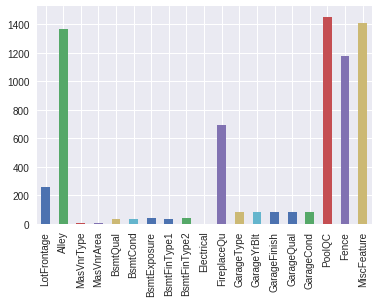

In [726]:
faltando.plot.bar()

In [0]:
tabela_faltando = train[mostra_buraco()]

In [728]:
train[['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf
5,Gd,TA,No,GLQ,Unf
6,Ex,TA,Av,GLQ,Unf
7,Gd,TA,Mn,ALQ,BLQ
8,TA,TA,No,Unf,Unf
9,TA,TA,No,GLQ,Unf


Temos vários nans, como visto na parte acima. Podemos fazer duas abordagens:

   - Imputar novos valores
  
   - Dropar os dados que contém nans

**Dicionário das features faltando**

    - LotFrontage -> Frente do lote

    - Alley -> Tipo de beco para acessar a propriedade
    
    - MasVnrType -> 
    
    - BsmtXXXX -> variáveis do porão
    
    - Eletrical
    
    - FireplaceQu -> Quantidade de lareiras
    
    - GarageXXX   -> Variáveis relacionadas a garagem
    
    - PoolQc    -> Quantidade de piscina???
    
    - Fence   -> Tipo de certa/presença de
    
    - MiscFeature -> ??????

#Cuidando dos NaNs



---


**LotFrontage/LotArea**

In [729]:
# bora ver a correlação entra a LotFrontage e a LotArea já que a Area não tem valores faltando

train['LotFrontage'].corr(train['LotArea'])

0.42609501877180833

A correlação não é tão grande porque é complicado comparar
Uma dimensão quadrática (Area) com uma linear.

Vamos assumir que os lotes são quadrados e criar uma nova feature

In [0]:
train['Lado_do_lote'] = np.sqrt(train['LotArea'])
test['Lado_do_lote'] = np.sqrt(test['LotArea'])

Vamos agora ve a correlação entre as features


In [731]:
train['LotFrontage'].corr(train['Lado_do_lote'])

0.6020022167939361

A correlação não é tão alta porque não dá para assumir que são retangulares. Todavia, iremos asumir que os lotes faltantes são

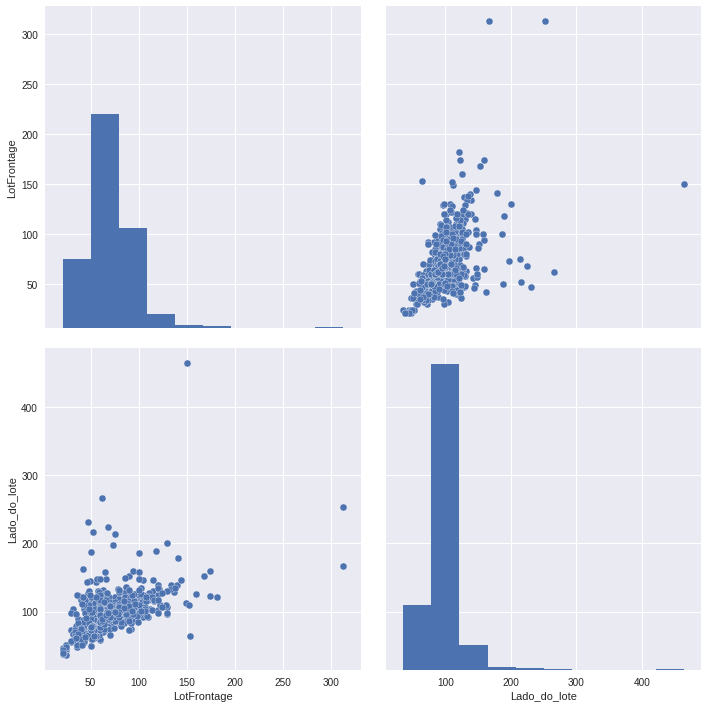

In [732]:
sbs.pairplot(data=train[['LotFrontage','Lado_do_lote']].dropna(), size=5)

Nesse pairplot, vemos que é razoável assumir que alguns terrenos podem ser quadrados

In [0]:
condicao = train['LotFrontage'].isnull()
condicao_test = test['LotFrontage'].isnull()

train.LotFrontage[condicao] = train.Lado_do_lote[condicao]
test.LotFrontage[condicao_test] = test.Lado_do_lote[condicao_test]

Agora, já que o lado do lote já cumpriu seu papel, irei dropar essa feature

In [0]:
train = train.drop('Lado_do_lote',axis=1)
test  = test.drop('Lado_do_lote', axis=1)

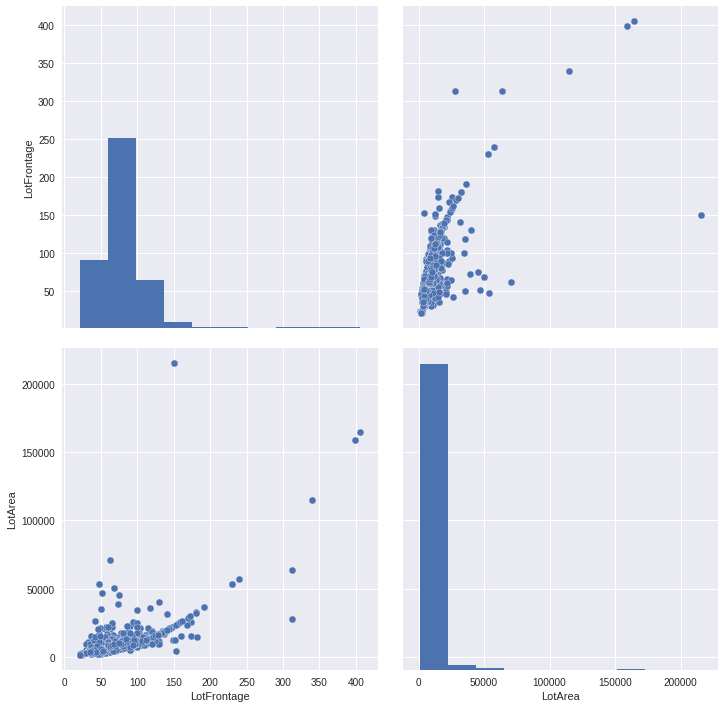

In [735]:
sbs.pairplot(data=train[['LotFrontage','LotArea']], size=5)

Nesse gráfico acima, vemos o motivo do coeficiente de correlação ter dado tão ruim para a comparação
Entre área e comprimento. Observe o comportamento quadrático

**Alley**

Primeiro, vamos ver quais os tipos dos Alley

In [736]:
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

Temos poucas casas com becos, e eles são: 

    - Pavimentados
    - Calçados
    
 Temos poucos elementos que tem Alley, a justificativa disso pode ser que as casas não terem acesso por beco. 
 
 Logo, trocarei NaN por None

In [0]:
# Bora imputar os valores

train.loc[train['Alley'].isnull(),'Alley'] = 'None'
test.loc[test['Alley'].isnull(),'Alley'] = 'None'

In [738]:
train['Alley'].value_counts()

None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

In [739]:
test['Alley'].value_counts()

None    1352
Grvl      70
Pave      37
Name: Alley, dtype: int64

MasVnr

In [740]:
train[['MasVnrType','MasVnrArea']][train['MasVnrType'].isnull()==True]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


Todos os valores de MasVnRXXXX que faltam estão na mesma linha, vou subistituir-los pelos mais frequentes

In [741]:
train['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

Agora, como None é o mais frequente do tipo, vou por 0.0 na area

In [0]:
# Bora imputar os valores

train.loc[train['MasVnrType'].isnull(),'MasVnrType'] = 'None'

train.loc[train['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0

test.loc[test['MasVnrType'].isnull(),'MasVnrType'] = 'None'

test.loc[test['MasVnrArea'].isnull(), 'MasVnrArea'] = 0.0


**Basement**

In [0]:

basement_cols = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

for cols in basement_cols:
    if 'FinSF'not in cols:
        train.loc[train[cols].isnull(),cols] = 'None'
        test.loc[test[cols].isnull(),cols] = 'None'



**Electrical**

In [0]:
def mostra_dados(df, coluna):
  return df[coluna].value_counts()

def preenche_nans(df, coluna,valor):
  df.loc[df[coluna].isnull(),coluna] = valor


In [745]:
mostra_dados(train,'Electrical')

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [746]:
mostra_dados(test, 'Electrical')

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64

O típo de rede elétrica mais utilizada é o SBrkr, vou imputar ele no lugar dos nans por ser o mais frequente. 

Pois, a probabilidade dessas caras que não tem isso preenchido ser SBrkr, é a maior possível dentre as escolhas.

In [0]:
preenche_nans(train, 'Electrical','SBrkr')
preenche_nans(test, 'Electrical','SBrkr')

**Fireplace**

In [748]:
mostra_dados(train,'FireplaceQu')

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [749]:
mostra_dados(test, 'FireplaceQu')

Gd    364
TA    279
Fa     41
Po     26
Ex     19
Name: FireplaceQu, dtype: int64

In [750]:
faltando['FireplaceQu']

690

Olhando a distribuição de Fireplaces por casa, vemos que o mais comum é não ter Fireplace

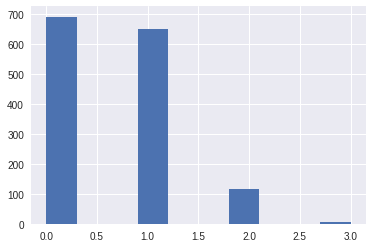

In [751]:
train['Fireplaces'].hist()

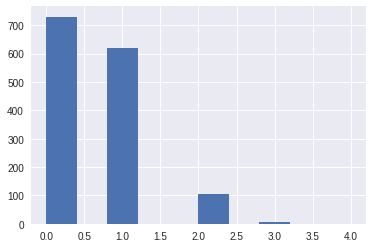

In [752]:
test['Fireplaces'].hist()

Vou assumir que os NaN quanto a fireplace são de pessoas que não tem fireplace.

In [0]:
preenche_nans(train, 'FireplaceQu','None')
preenche_nans(test, 'FireplaceQu', 'None')

In [754]:
pd.crosstab(train['Fireplaces'],train['FireplaceQu'])

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


Isso mostra que a nossa assunção foi razoável

**Garages**

In [755]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']

train[garage_cols][train['GarageType'].isnull() == True]

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0,0
48,NaN,NaN,NaN,NaN,NaN,0,0
78,NaN,NaN,NaN,NaN,NaN,0,0
88,NaN,NaN,NaN,NaN,NaN,0,0
89,NaN,NaN,NaN,NaN,NaN,0,0
99,NaN,NaN,NaN,NaN,NaN,0,0
108,NaN,NaN,NaN,NaN,NaN,0,0
125,NaN,NaN,NaN,NaN,NaN,0,0
127,NaN,NaN,NaN,NaN,NaN,0,0
140,NaN,NaN,NaN,NaN,NaN,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc715d7aba8>,
      dtype=object)

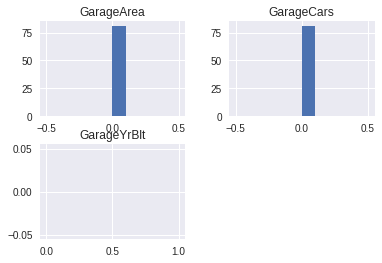

In [756]:
train[garage_cols][train['GarageType'].isnull() == True].hist()

Vemos que essas casas que não colocaram que tinham garagem simplesmente não tem mesmo.

Portanto, preencherei com None

In [0]:
for cols in garage_cols:
  # Caso em que tenhamos uma variável categórica
  if train[cols].dtype == np.object:
    preenche_nans(train,cols,'None')
    preenche_nans(test,cols,'None')
  # Caso em que tenhamos variáveis numéricas
  else:
    preenche_nans(test,cols,0)
    preenche_nans(test,cols,0)

**Piscina**

In [758]:
mostra_dados(train,'PoolQC')

Gd    3
Fa    2
Ex    2
Name: PoolQC, dtype: int64

Tem poucos dados não nulos, com respetio a qualidade das piscinas

Todavia, será que sempre que não tem dados, não tem piscina na casa?

Vamos fazer o seguinte: ver se as casas que não declararam esse parâmetro tem piscina, ao impor a seguinte condição:

Será que a área da piscina dessas casas é não nula?

In [759]:
train['PoolArea'][train['PoolQC'].isnull() == True].describe()

count    1453.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: PoolArea, dtype: float64

In [760]:
test['PoolArea'][test['PoolQC'].isnull() == True].describe()

count    1456.000000
mean        0.942995
std        21.070757
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       561.000000
Name: PoolArea, dtype: float64

O banco de dados tem 1460 elementos, temos apenas 7 pessoas que declararam a qualidade da piscina. 

Então, esse resto que não declarou, de fato, não tme piscina em suas casas. Pois o valor máximo das áreas da piscina das pessoas que 
não declararam é 0

In [0]:
preenche_nans(train,'PoolQC','None')

preenche_nans(test,'PoolQC','None')

**Fence**

Vou assumir que as pessoas que não declararam que tem cerca, simplesmente não as tem

In [0]:
preenche_nans(train, 'Fence','None')
preenche_nans(test, 'Fence','None')


**MiscFeature**

Se a pessoa não declarou que tenha uma característica desse tipo, vou assumir que ela não tem

In [0]:
preenche_nans(train,'MiscFeature','None')
preenche_nans(test,'MiscFeature','None')

In [764]:
test[mostra_buraco_test()].isnull().sum()

MSZoning        4
Utilities       2
Exterior1st     1
Exterior2nd     1
BsmtFinSF1      1
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
SaleType        1
dtype: int64

In [765]:
test[test['TotalBsmtSF'].isnull() == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
660,2121,20,RM,99.0,5940,Pave,None,IR1,Lvl,AllPub,...,0,0,None,MnPrv,None,0,4,2008,ConLD,Abnorml


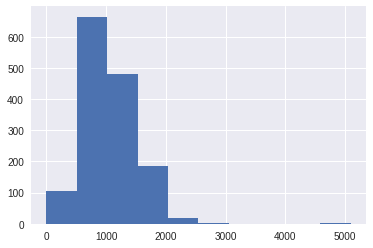

In [766]:
test['TotalBsmtSF'].hist()

In [0]:
mean = test['TotalBsmtSF'].mean()

Vou preencher esse valor que falta com o valor médio, para não prejudicar a estatística do modelo

In [0]:
preenche_nans(test, 'TotalBsmtSF', mean)

##Dummyficar



In [0]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Hora da  limpeza por correlação!

In [0]:
import scipy
import scipy.cluster.hierarchy as sch

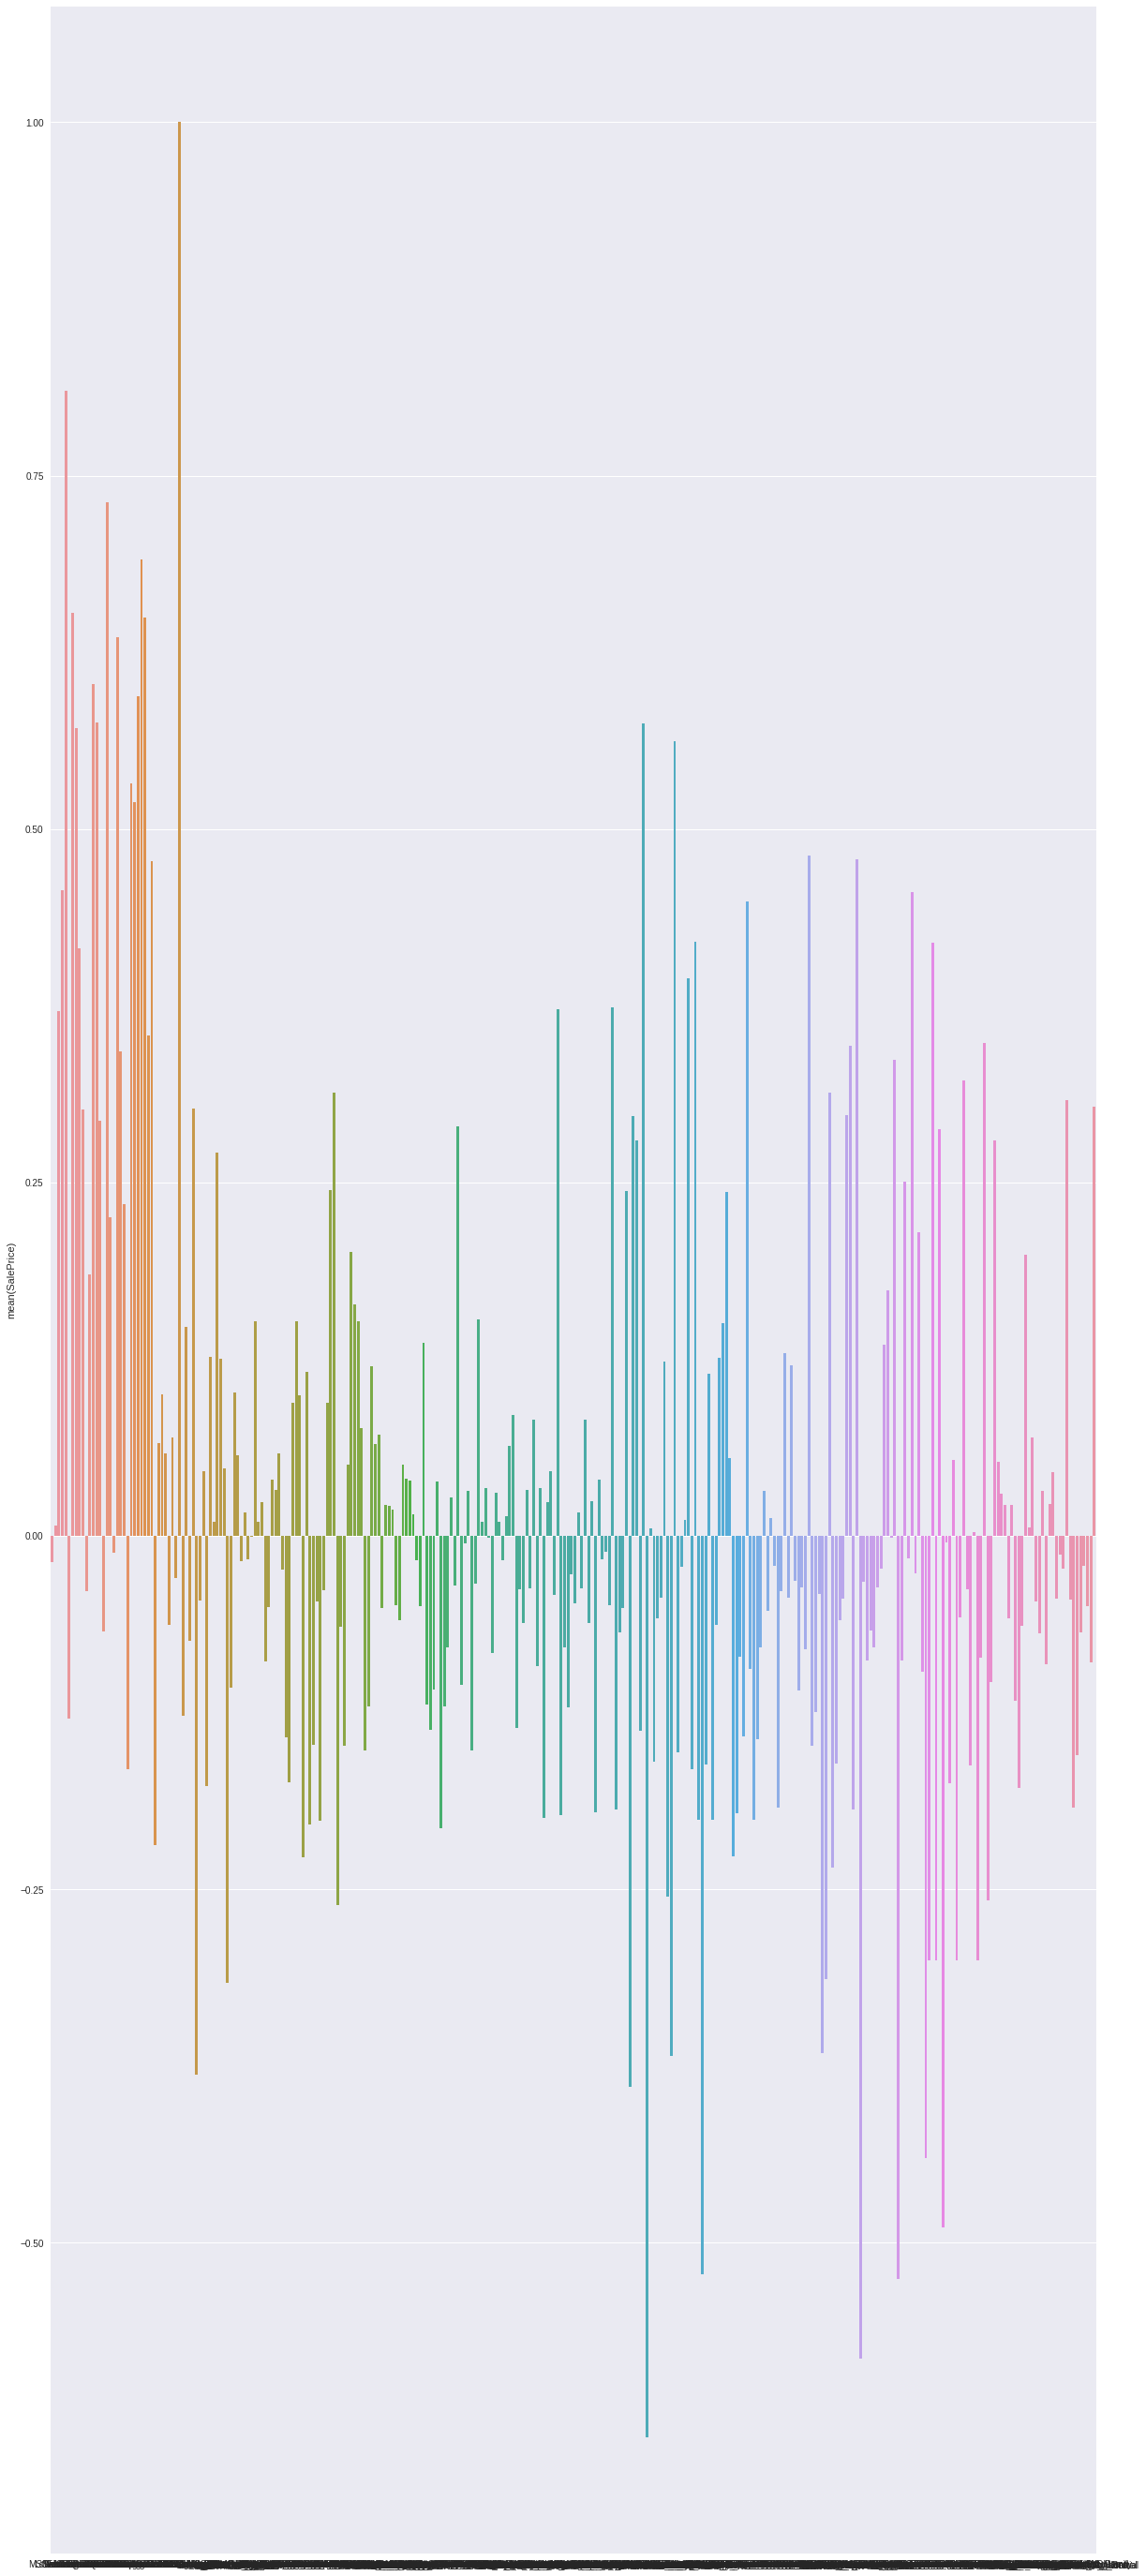

In [771]:
corr = train.corr(method='spearman')

corr_preco_de_venda = corr['SalePrice']


plt.figure(figsize=(20,50))
#corr_preco_de_venda
sbs.barplot(x=corr_preco_de_venda.index,y=corr_preco_de_venda)

Vou adotar um threshold de correlação de $|0.25|$

Jogarei fora todas as correlações que o módulo seja menor que isso

In [0]:
nova_corr = corr_preco_de_venda[np.abs(corr_preco_de_venda) >= 0.25]

[Text(0, 0, 'LotFrontage'),
 Text(0, 0, 'LotArea'),
 Text(0, 0, 'OverallQual'),
 Text(0, 0, 'YearBuilt'),
 Text(0, 0, 'YearRemodAdd'),
 Text(0, 0, 'MasVnrArea'),
 Text(0, 0, 'BsmtFinSF1'),
 Text(0, 0, 'TotalBsmtSF'),
 Text(0, 0, '1stFlrSF'),
 Text(0, 0, '2ndFlrSF'),
 Text(0, 0, 'GrLivArea'),
 Text(0, 0, 'FullBath'),
 Text(0, 0, 'HalfBath'),
 Text(0, 0, 'TotRmsAbvGrd'),
 Text(0, 0, 'Fireplaces'),
 Text(0, 0, 'GarageYrBlt'),
 Text(0, 0, 'GarageCars'),
 Text(0, 0, 'GarageArea'),
 Text(0, 0, 'WoodDeckSF'),
 Text(0, 0, 'OpenPorchSF'),
 Text(0, 0, 'SalePrice'),
 Text(0, 0, 'MSZoning_RL'),
 Text(0, 0, 'MSZoning_RM'),
 Text(0, 0, 'LotShape_IR1'),
 Text(0, 0, 'LotShape_Reg'),
 Text(0, 0, 'Neighborhood_NridgHt'),
 Text(0, 0, 'Neighborhood_OldTown'),
 Text(0, 0, 'HouseStyle_2Story'),
 Text(0, 0, 'Exterior1st_VinylSd'),
 Text(0, 0, 'Exterior2nd_VinylSd'),
 Text(0, 0, 'MasVnrType_None'),
 Text(0, 0, 'MasVnrType_Stone'),
 Text(0, 0, 'ExterQual_Ex'),
 Text(0, 0, 'ExterQual_Gd'),
 Text(0, 0, 'ExterQua

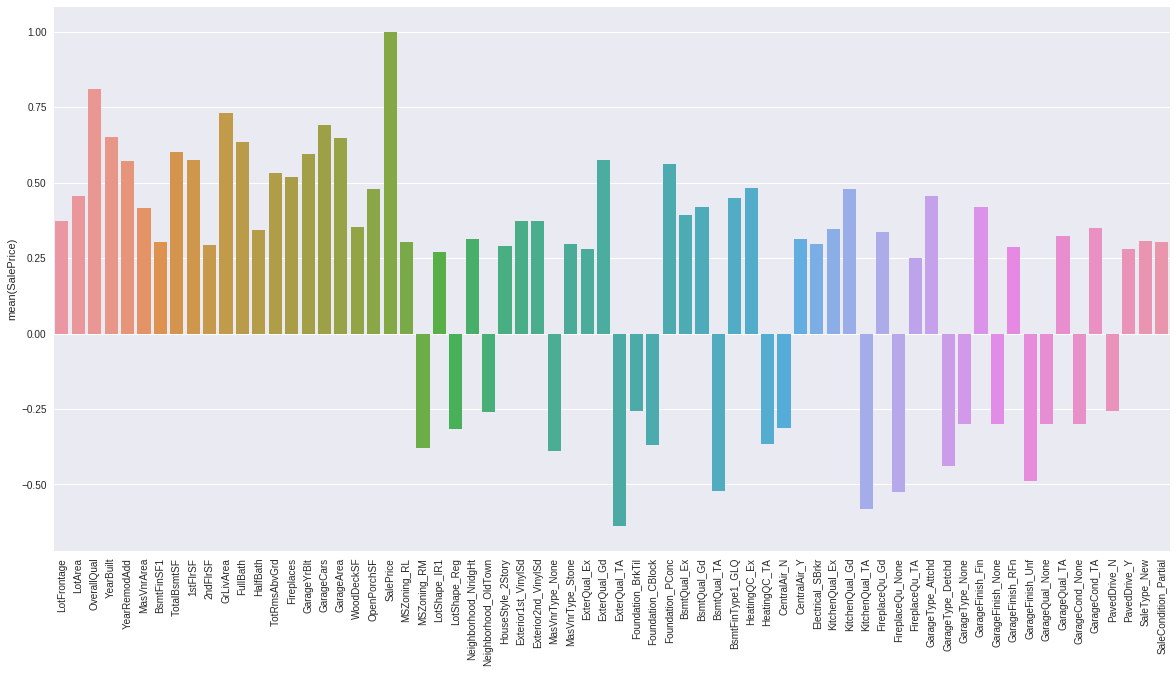

In [773]:
plt.figure(figsize=(20,10))

g = sbs.barplot(x=nova_corr.index,y=nova_corr)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

In [0]:
labels_relevantes = nova_corr.index.values
#treino_filtro1    = train[labels_relevantes]
#treino_filtro1

In [775]:
labels_relevantes

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice',
       'MSZoning_RL', 'MSZoning_RM', 'LotShape_IR1', 'LotShape_Reg',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown',
       'HouseStyle_2Story', 'Exterior1st_VinylSd', 'Exterior2nd_VinylSd',
       'MasVnrType_None', 'MasVnrType_Stone', 'ExterQual_Ex',
       'ExterQual_Gd', 'ExterQual_TA', 'Foundation_BrkTil',
       'Foundation_CBlock', 'Foundation_PConc', 'BsmtQual_Ex',
       'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtFinType1_GLQ', 'HeatingQC_Ex',
       'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_SBrkr',
       'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA',
       'FireplaceQu_Gd', 'FireplaceQu_None', 'FireplaceQu_TA',
       'GarageType_At

In [0]:
labels_relevantes = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
                     'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
                     'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
                     'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                     'OpenPorchSF', 'SalePrice', 'MSZoning_RL', 'MSZoning_RM',
                     'LotShape_IR1', 'LotShape_Reg', 'Neighborhood_NoRidge',
                     'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
                     'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip',
                     'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrType_None',
                     'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA',
                     'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
                     'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_Gd',
                     'BsmtExposure_No', 'BsmtFinType1_GLQ', 'HeatingQC_Ex',
                     'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_SBrkr',
                     'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA',
                     'FireplaceQu_Ex', 'FireplaceQu_Gd', 'FireplaceQu_None',
                     'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_Detchd',
                     'GarageType_None', 'GarageFinish_Fin', 'GarageFinish_None',
                     'GarageFinish_Unf', 'GarageQual_None', 'GarageQual_TA',
                     'GarageCond_None', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_Y',
                     'SaleType_New', 'SaleType_WD', 'SaleCondition_Partial'
                     ]

labels_relevantes_test = ['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
                          'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
                          'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',
                          'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
                          'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
                          'OpenPorchSF', 'MSZoning_RL', 'MSZoning_RM',
                          'LotShape_IR1', 'LotShape_Reg', 'Neighborhood_NoRidge',
                          'Neighborhood_NridgHt', 'Neighborhood_StoneBr',
                          'HouseStyle_2Story', 'RoofStyle_Gable', 'RoofStyle_Hip',
                          'Exterior1st_VinylSd', 'Exterior2nd_VinylSd', 'MasVnrType_None',
                          'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA',
                          'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
                          'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA', 'BsmtExposure_Gd',
                          'BsmtExposure_No', 'BsmtFinType1_GLQ', 'HeatingQC_Ex',
                          'HeatingQC_TA', 'CentralAir_N', 'CentralAir_Y', 'Electrical_SBrkr',
                          'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA',
                          'FireplaceQu_Ex', 'FireplaceQu_Gd', 'FireplaceQu_None',
                          'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_Detchd',
                          'GarageType_None', 'GarageFinish_Fin', 'GarageFinish_None',
                          'GarageFinish_Unf', 'GarageQual_None', 'GarageQual_TA',
                          'GarageCond_None', 'GarageCond_TA', 'PavedDrive_N', 'PavedDrive_Y',
                          'SaleType_New', 'SaleType_WD', 'SaleCondition_Partial'
                           ]


train = train[labels_relevantes]
test  = test[labels_relevantes_test]

In [777]:
train.head(5)

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,GarageFinish_Unf,GarageQual_None,GarageQual_TA,GarageCond_None,GarageCond_TA,PavedDrive_N,PavedDrive_Y,SaleType_New,SaleType_WD,SaleCondition_Partial
0,65.0,8450,7,2003,2003,196.0,706,150,856,856,...,0,0,1,0,1,0,1,0,1,0
1,80.0,9600,6,1976,1976,0.0,978,284,1262,1262,...,0,0,1,0,1,0,1,0,1,0
2,68.0,11250,7,2001,2002,162.0,486,434,920,920,...,0,0,1,0,1,0,1,0,1,0
3,60.0,9550,7,1915,1970,0.0,216,540,756,961,...,1,0,1,0,1,0,1,0,1,0
4,84.0,14260,8,2000,2000,350.0,655,490,1145,1145,...,0,0,1,0,1,0,1,0,1,0


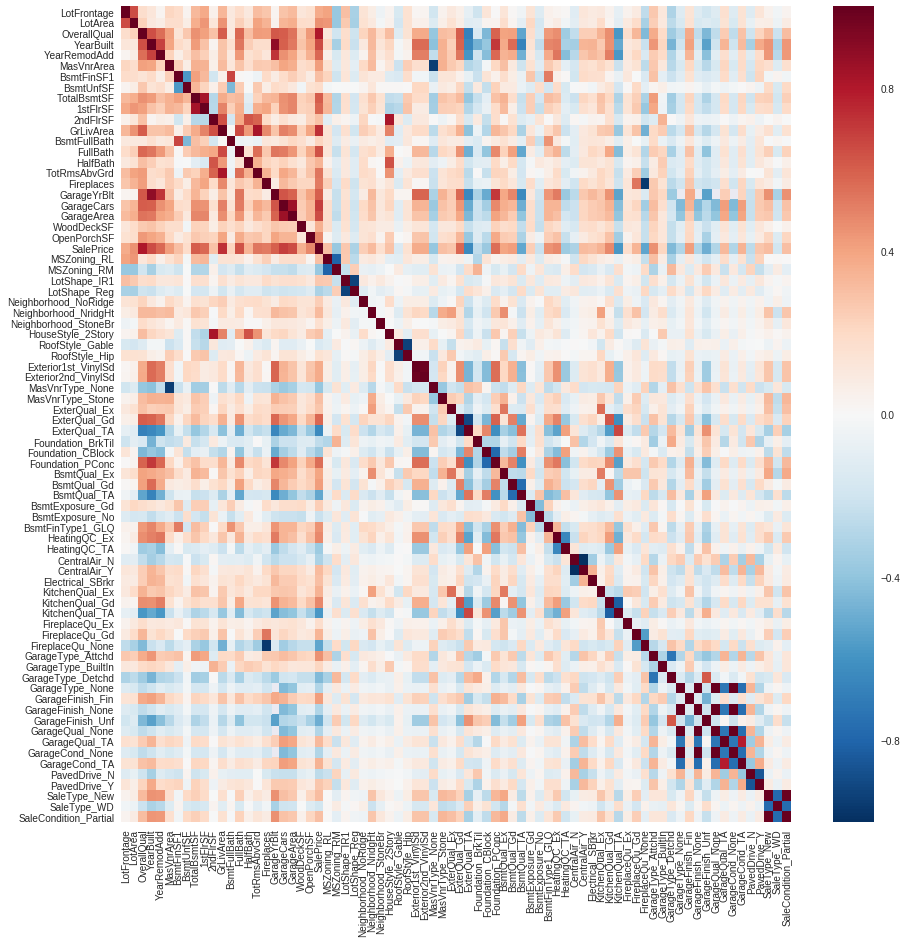

In [778]:
new_corr = train.corr(method='spearman')

plt.figure(figsize=(15,15))

sbs.heatmap(
            new_corr,
           )

Vemos aí que , nítidamente, temos umas features que são redundantes -- por exemplo (Linhas que são espelhadas {tipo função ímpar}):

    - Variáveis binárias do tipo Y ou N (PavedDrive_N/CentralAir)
    
    - O Ano de construção da garagem é extremamente corelacionado com o ano de construção da casa, portanto irei remover-lo
    
    - KitchenQual_TA, ExterQual_TA, HeatingQC_TA, FireplaceQu_Gd, GarageType_Detchd, BsmtQual_TA,GarageFinish_Unf

In [0]:
train = train.drop(['PavedDrive_N','CentralAir_N','GarageYrBlt', 'KitchenQual_TA',
                    'ExterQual_TA', 'HeatingQC_TA', 'FireplaceQu_Gd', 'GarageType_Detchd',
                    'BsmtQual_TA', 'GarageFinish_Unf', 'MSZoning_RM', 'Exterior2nd_VinylSd',
                    'Foundation_CBlock', 'GarageCond_None', 'GarageQual_TA', 'BsmtUnfSF',
                    'GarageCars', 'RoofStyle_Gable', 'GarageFinish_None', 'GarageQual_None'
                   ], axis = 1)
test = test.drop(['PavedDrive_N','CentralAir_N','GarageYrBlt', 'KitchenQual_TA',
                    'ExterQual_TA', 'HeatingQC_TA', 'FireplaceQu_Gd', 'GarageType_Detchd',
                    'BsmtQual_TA', 'GarageFinish_Unf', 'MSZoning_RM', 'Exterior2nd_VinylSd',
                    'Foundation_CBlock', 'GarageCond_None', 'GarageQual_TA', 'BsmtUnfSF',
                    'GarageCars', 'RoofStyle_Gable', 'GarageFinish_None', 'GarageQual_None'
                   ], axis = 1)

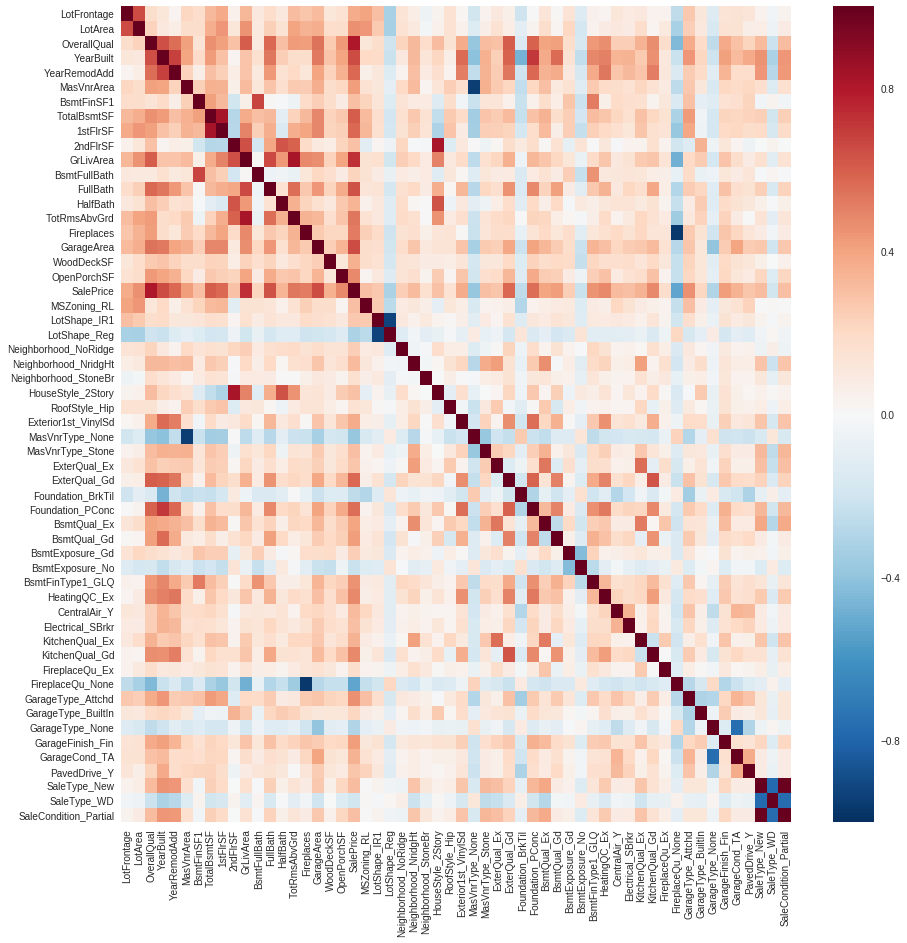

In [780]:
new_corr = train.corr(method='spearman')

plt.figure(figsize=(15,15))

sbs.heatmap(
            new_corr,
           )

Com essa matriz de correlação menor, vemos, mais facilmente, que temos mais variáveis que se enquadram na nossa definição anterior

Vamos facilitar a visualização da matriz de correlação ao clusterizar ela

In [0]:
import scipy.cluster.hierarchy as spc

In [0]:
def plot_corr(df,size=10):
    '''Plot a graphical correlation matrix for a dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    # Compute the correlation matrix for the received dataframe
    corr = df.corr()
    
    # Plot the correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(corr, cmap='Spectral')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90);
    plt.yticks(range(len(corr.columns)), corr.columns);
    
    # Add the colorbar legend
    cbar = fig.colorbar(cax, ticks=[-1, 0, 1], aspect=40, shrink=.8)

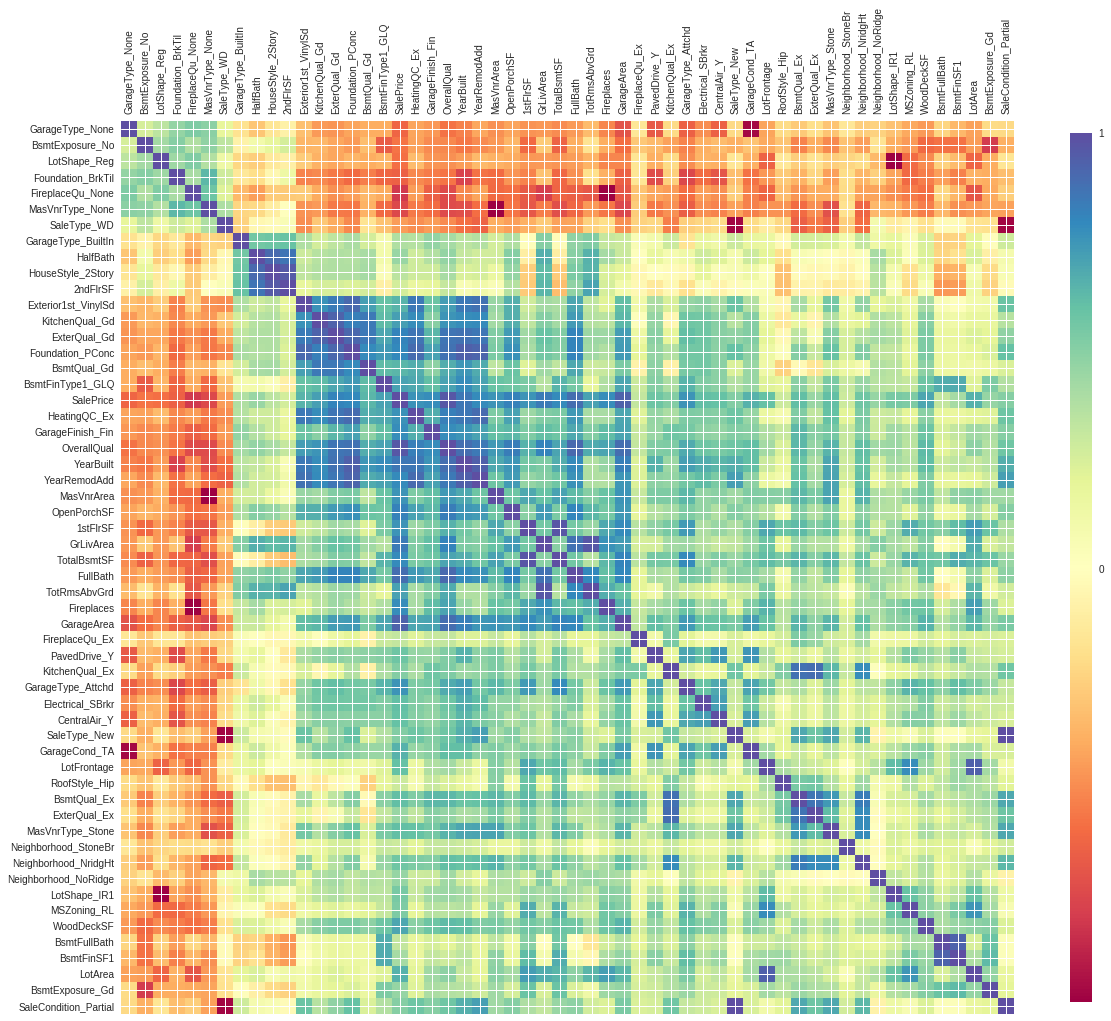

In [783]:
new_corr = train.corr(method='spearman')

pdist = spc.distance.pdist(new_corr)

linkage =  spc.linkage(pdist, method='complete')

idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')


colunas = [new_corr.columns.tolist()[i] for i in list((np.argsort(idx)))]

teste = new_corr.reindex_axis(colunas, axis=1)

plot_corr(teste,20)

In [784]:
train.columns

Index(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice',
       'MSZoning_RL', 'LotShape_IR1', 'LotShape_Reg', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_StoneBr', 'HouseStyle_2Story',
       'RoofStyle_Hip', 'Exterior1st_VinylSd', 'MasVnrType_None',
       'MasVnrType_Stone', 'ExterQual_Ex', 'ExterQual_Gd', 'Foundation_BrkTil',
       'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtExposure_Gd',
       'BsmtExposure_No', 'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'CentralAir_Y',
       'Electrical_SBrkr', 'KitchenQual_Ex', 'KitchenQual_Gd',
       'FireplaceQu_Ex', 'FireplaceQu_None', 'GarageType_Attchd',
       'GarageType_BuiltIn', 'GarageType_None', 'GarageFinish_Fin',
       'GarageCond_TA', 'PavedDrive_Y', 'Sale

#Hora de ver as distribuições!

In [0]:
from scipy import stats

## Estudo da distribuição dos preços

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



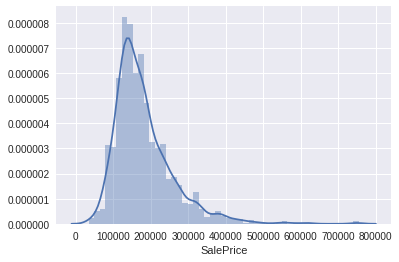

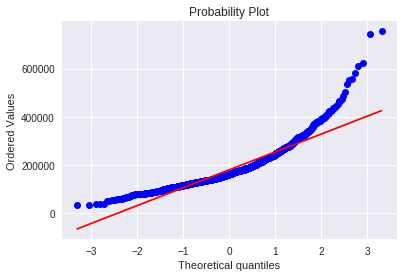

In [786]:
sbs.distplot(train['SalePrice']);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

  A distribuição dos preços não está normalizada, aparentemente está obedecendo uma distribuição Log-Normal
  
  Todavia, vamos analizar se essa hipótese se confirma

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning:


The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.



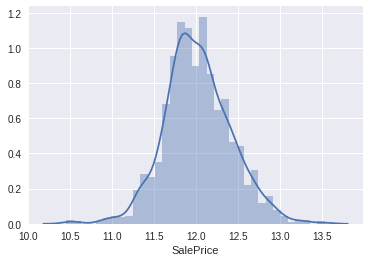

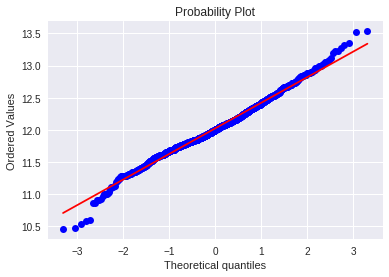

In [787]:
sbs.distplot(np.log(train['SalePrice']));
fig = plt.figure()
             
res = stats.probplot(np.log(train['SalePrice']), plot=plt)

Vamos ver o comportamento geral dos dados

In [0]:
#pd.scatter_matrix(
#                  train 
#                 )

In [0]:
# Vou pegar as variáveis com correlação maior que 0.5
new_corr = train.corr(method='spearman')

preco_venda = new_corr['SalePrice'][np.abs(new_corr['SalePrice']) >= 0.4]

In [790]:
preco_venda

LotArea              0.456461
OverallQual          0.809829
YearBuilt            0.652682
YearRemodAdd         0.571159
MasVnrArea           0.415906
TotalBsmtSF          0.602725
1stFlrSF             0.575408
GrLivArea            0.731310
FullBath             0.635957
TotRmsAbvGrd         0.532586
Fireplaces           0.519247
GarageArea           0.649379
OpenPorchSF          0.477561
SalePrice            1.000000
ExterQual_Gd         0.574642
Foundation_PConc     0.562287
BsmtQual_Gd          0.420404
BsmtFinType1_GLQ     0.448915
HeatingQC_Ex         0.481235
KitchenQual_Gd       0.478583
FireplaceQu_None    -0.525735
GarageType_Attchd    0.455399
GarageFinish_Fin     0.419392
Name: SalePrice, dtype: float64

[Text(0, 0, 'LotArea'),
 Text(0, 0, 'OverallQual'),
 Text(0, 0, 'YearBuilt'),
 Text(0, 0, 'YearRemodAdd'),
 Text(0, 0, 'MasVnrArea'),
 Text(0, 0, 'TotalBsmtSF'),
 Text(0, 0, '1stFlrSF'),
 Text(0, 0, 'GrLivArea'),
 Text(0, 0, 'FullBath'),
 Text(0, 0, 'TotRmsAbvGrd'),
 Text(0, 0, 'Fireplaces'),
 Text(0, 0, 'GarageArea'),
 Text(0, 0, 'OpenPorchSF'),
 Text(0, 0, 'SalePrice'),
 Text(0, 0, 'ExterQual_Gd'),
 Text(0, 0, 'Foundation_PConc'),
 Text(0, 0, 'BsmtQual_Gd'),
 Text(0, 0, 'BsmtFinType1_GLQ'),
 Text(0, 0, 'HeatingQC_Ex'),
 Text(0, 0, 'KitchenQual_Gd'),
 Text(0, 0, 'FireplaceQu_None'),
 Text(0, 0, 'GarageType_Attchd'),
 Text(0, 0, 'GarageFinish_Fin')]

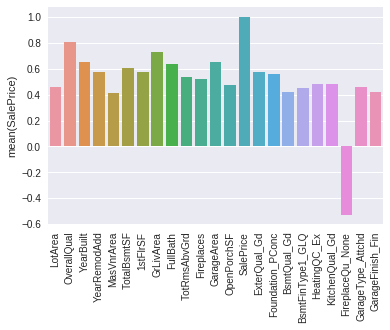

In [791]:
g = sbs.barplot(x=preco_venda.index,y=preco_venda)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

### Análise dessas features de maior correlação

In [0]:
labels_para_testar = preco_venda.index.values

In [793]:
labels_para_testar

array(['LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'OpenPorchSF',
       'SalePrice', 'ExterQual_Gd', 'Foundation_PConc', 'BsmtQual_Gd',
       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'KitchenQual_Gd',
       'FireplaceQu_None', 'GarageType_Attchd', 'GarageFinish_Fin'],
      dtype=object)

In [0]:
labels_para_testar2 = [
                       'LotArea', 'OverallQual', 'YearBuilt', 'YearRemodAdd',
                       'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath',
                       'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'OpenPorchSF',
                       'ExterQual_Gd', 'Foundation_PConc', 'BsmtQual_Gd',
                       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'KitchenQual_Gd',
                       'FireplaceQu_None', 'GarageType_Attchd', 'GarageFinish_Fin'
                      ]

In [0]:
testar = train[labels_para_testar]

In [796]:
testar.head()

,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,...,SalePrice,ExterQual_Gd,Foundation_PConc,BsmtQual_Gd,BsmtFinType1_GLQ,HeatingQC_Ex,KitchenQual_Gd,FireplaceQu_None,GarageType_Attchd,GarageFinish_Fin
0,8450,7,2003,2003,196.0,856,856,1710,2,8,...,208500,1,1,1,1,1,1,1,1,0
1,9600,6,1976,1976,0.0,1262,1262,1262,2,6,...,181500,0,0,1,0,1,0,0,1,0
2,11250,7,2001,2002,162.0,920,920,1786,2,6,...,223500,1,1,1,1,1,1,0,1,0
3,9550,7,1915,1970,0.0,756,961,1717,1,7,...,140000,0,0,0,0,0,1,0,0,0
4,14260,8,2000,2000,350.0,1145,1145,2198,2,9,...,250000,1,1,1,1,1,1,0,1,0


In [0]:

categoricas = ['ExterQual_Gd', 'Foundation_PConc', 'GarageFinish_Fin', 'GarageType_Attchd', 'FireplaceQu_None', 
               'KitchenQual_Gd', 'HeatingQC_Ex', 'BsmtFinType1_GLQ', 'BsmtQual_Gd', 'Foundation_PConc', 'FullBath',
               'Fireplaces'
              ]

testar = testar.drop(categoricas, axis=1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc714b03048>,
      dtype=object)

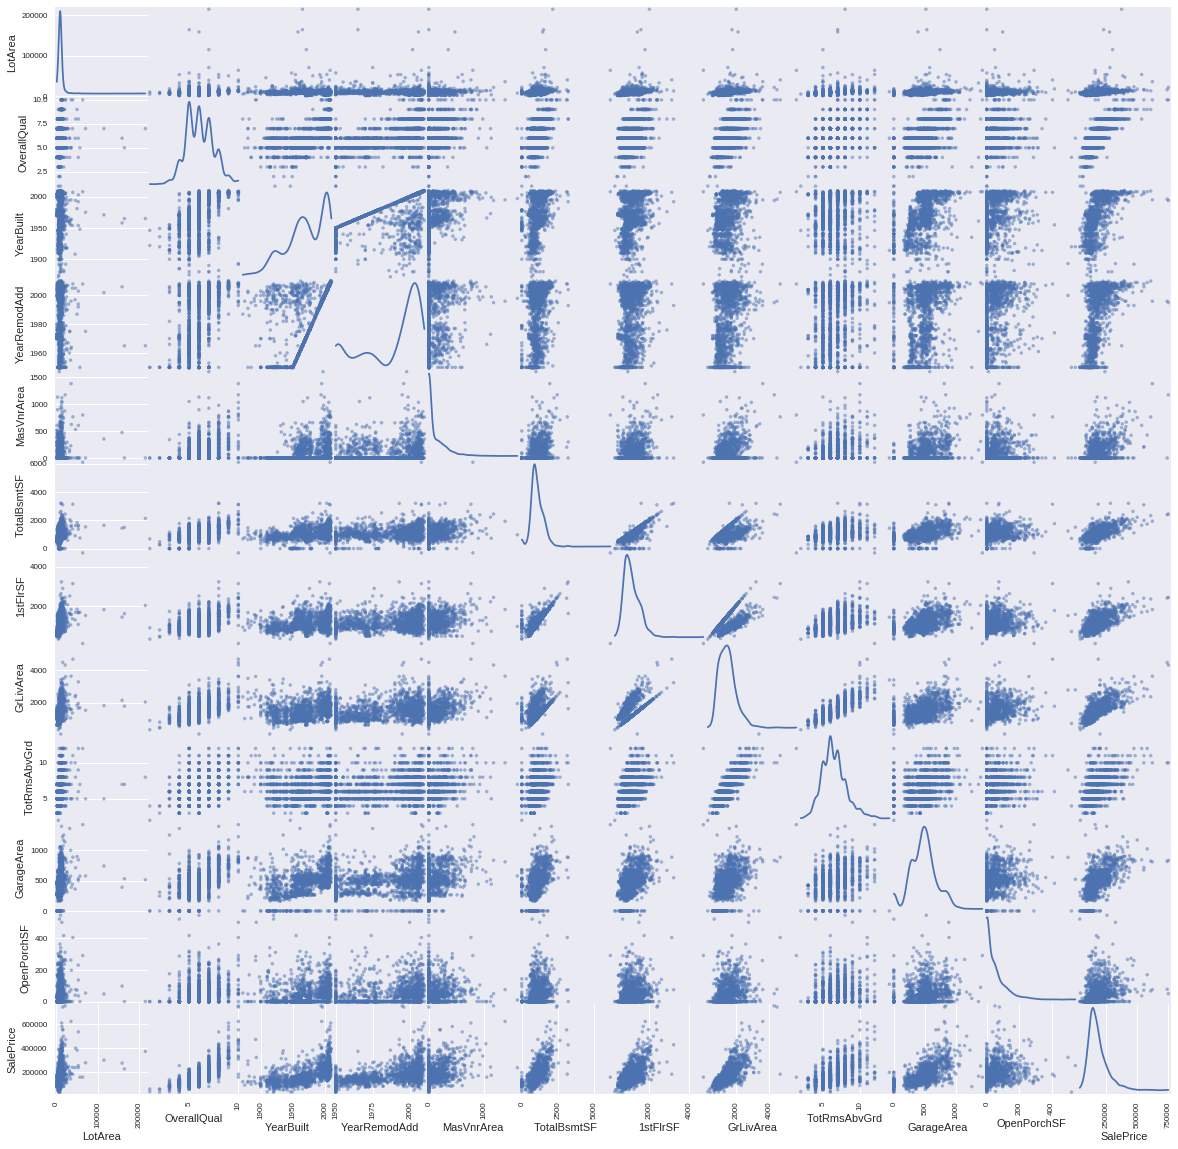

In [798]:
pd.plotting.scatter_matrix(testar, figsize=(20,20), diagonal='kde')

# Hora da predição!

Vou utilizar apenas esses dados memso que possuem correlação cujo módulo é maior que $0.5$

In [0]:
from sklearn.model_selection import train_test_split

train = train[labels_para_testar]
test  = test[labels_para_testar2]

trainX = train
trainY = trainX['SalePrice']
trainX = trainX.drop('SalePrice', axis=1)

#### Bora melhorar a qualidade das inputs do modelo ao utilizar PCA

In [0]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler

scaler = StandardScaler() # Normalizar a variância para 1

In [801]:
test.isna().sum()

LotArea              0
OverallQual          0
YearBuilt            0
YearRemodAdd         0
MasVnrArea           0
TotalBsmtSF          0
1stFlrSF             0
GrLivArea            0
FullBath             0
TotRmsAbvGrd         0
Fireplaces           0
GarageArea           0
OpenPorchSF          0
ExterQual_Gd         0
Foundation_PConc     0
BsmtQual_Gd          0
BsmtFinType1_GLQ     0
HeatingQC_Ex         0
KitchenQual_Gd       0
FireplaceQu_None     0
GarageType_Attchd    0
GarageFinish_Fin     0
dtype: int64

In [802]:
X_scaled = scaler.fit(trainX).transform(trainX)
test_scaled = scaler.fit(test).transform(test)

y_target     = trainY
y_log_target = np.log(trainY)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.



In [803]:
X_scaled.shape

(1460, 22)

Text(0, 0.5, 'Variance (Energia) (%)')

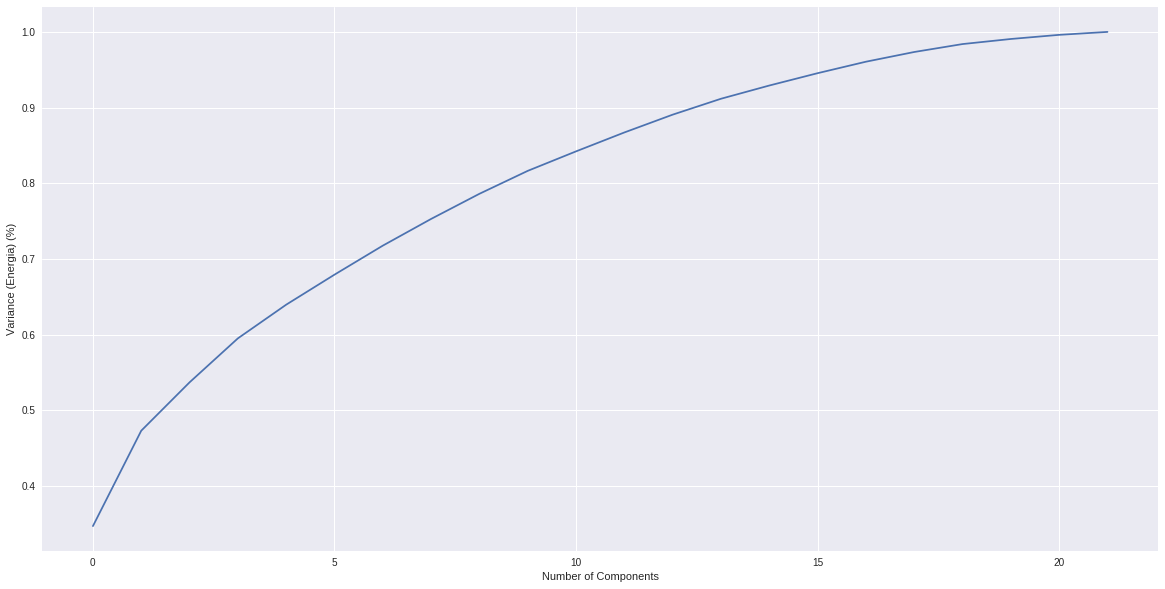

In [804]:
pca  = PCA(n_components=22).fit(X_scaled)
pca2 = PCA(n_components=22).fit(test_scaled) 

plt.figure(figsize=(20,10))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (Energia) (%)') #for each component

In [0]:
pca = PCA(n_components= 22)

In [0]:
X_scaled = pca.fit_transform(X_scaled)

In [0]:
test_scaled = PCA(n_components=22).fit_transform(test_scaled)

In [0]:
X_scaled = pd.DataFrame(X_scaled)
test_scaled = pd.DataFrame(test_scaled)

In [0]:
X_scaled['SalePrice'] = trainY

In [809]:
X_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,SalePrice
0,2.319124,-2.627408,1.163448,0.626278,0.335421,-0.576250,-0.542503,0.582575,0.653298,0.200530,...,0.572532,0.048332,0.391236,-0.042742,-0.223832,-0.169815,0.198743,-0.095278,0.212450,208500
1,-0.045639,0.480719,-1.057605,-0.816045,0.487685,-0.554080,-0.458465,0.203707,-0.845106,-0.002676,...,-0.145071,-1.182285,0.095058,0.502877,0.573865,0.094093,0.298877,-0.243894,-0.180442,181500
2,2.840866,-1.756321,-0.251130,-1.139604,0.269199,-0.324771,-0.860677,0.126217,0.993750,0.433683,...,0.275238,0.029111,-0.169674,0.205136,-0.135471,0.268992,0.053240,0.376998,-0.280665,223500
3,-1.458830,1.561733,0.810107,-1.262373,0.171041,0.372986,-1.024603,-0.840572,0.583305,0.148728,...,-0.129234,0.058950,0.275084,-0.633742,1.255242,-0.054042,0.028951,-0.165346,-0.232857,140000
4,4.346786,-0.331784,0.666071,-0.220325,0.087142,-0.362141,-1.106719,0.395900,1.375804,0.173109,...,0.613809,-0.041532,0.560062,-0.265564,-0.177915,-0.054042,0.254564,-0.199440,-0.114397,250000


In [848]:
test_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.757994,0.268243,-1.354263,1.093514,0.504410,-0.698834,-0.240443,0.365720,-0.064715,0.218386,...,-0.993573,0.307576,-0.165527,0.240533,-0.066985,-0.010742,-0.000329,-0.291957,0.035407,0.079734
1,-1.647441,0.734373,-0.845489,1.616839,1.207049,0.073023,-0.607292,-0.003183,-1.007454,0.049379,...,-0.390400,0.088065,-0.455682,-0.132041,-0.568223,0.970861,-0.556780,-0.061648,0.164509,-0.105309
2,1.179523,-0.260928,-0.856093,-1.242486,-0.072342,-2.427273,1.558542,0.100833,1.525079,0.225085,...,-0.163878,-0.298154,-0.276346,0.404087,-0.462359,-0.337119,0.506630,-0.286498,0.522224,-0.265808
3,1.884969,-0.619060,-0.119558,-1.364815,-0.645112,-0.703134,0.567140,0.826963,0.016673,-0.808960,...,-1.361586,-0.108551,-0.111979,0.246787,-1.712571,0.121388,-0.446051,-0.291187,0.252815,-0.181175
4,1.525141,-2.717040,-0.078251,1.068523,0.863106,0.512942,-0.295663,-0.670774,-1.050491,-0.571436,...,0.723653,0.252259,0.449268,0.352292,0.215316,0.849941,0.207947,0.309738,-0.231750,0.218069


In [0]:
trainX, testX = train_test_split(X_scaled, test_size=0.1, random_state=42)

trainY = trainX['SalePrice']
log_trainY = np.log(trainY)
trainX = trainX.drop('SalePrice', axis=1)

In [0]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor


In [0]:
models = [ 
          LinearRegression(),
          Ridge(),
          Lasso(alpha=0.01,max_iter=10000),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          SVR(kernel='rbf'),
          LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),
          SGDRegressor(max_iter=1000,tol=1e-3),
          BayesianRidge(),
          KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),
          XGBRegressor()
         ]

In [0]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [814]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]

for name, model in zip(names, models):
    score = rmse_cv(model, trainX, log_trainY)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.166039, 0.0302
Ridge: 0.166009, 0.0302
Lasso: 0.169253, 0.0273
RF: 0.165163, 0.0175
GBR: 0.154949, 0.0149
SVR: 0.155190, 0.0181


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



LinSVR: 0.170541, 0.0382
Ela: 0.165694, 0.0301
SGD: 0.169606, 0.0254
Bay: 0.165648, 0.0299
Ker: 0.169121, 0.0298
Extra: 0.160952, 0.0147
Xgb: 0.155335, 0.0114


Os modelos mais diversos que obteram maior escore foram:

    - Xgb
    
    - ElasticNet 
    
    - SVR
    
    - Random Forest
    
  
  
E irei acrescentar um modelo que tenha um erro um pouco maior, para permitir um grau de "erro"

    - BayesianRidge

In [0]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error", n_jobs = -1)
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])


#### Xgb tuning

In [816]:
"""


grid(XGBRegressor()).grid_get(trainX, log_trainY, 
                             {
                              'learning_rate': [0.01, 0.02, 0.03, 0.05],
                              'min_child_weight': [1, 5, 10],
                              'gamma': [0.5, 1, 1.5, 2, 2.5],
                              'subsample': [0.6, 0.8, 1.0],
                              'colsample_bytree': [0.6, 0.8, 1.0],
                              'max_depth': [3, 4, 5, 6, 7 , 8]
                             }
                             )
"""

"\n\n\ngrid(XGBRegressor()).grid_get(trainX, log_trainY, \n                             {\n                              'learning_rate': [0.01, 0.02, 0.03, 0.05],\n                              'min_child_weight': [1, 5, 10],\n                              'gamma': [0.5, 1, 1.5, 2, 2.5],\n                              'subsample': [0.6, 0.8, 1.0],\n                              'colsample_bytree': [0.6, 0.8, 1.0],\n                              'max_depth': [3, 4, 5, 6, 7 , 8]\n                             }\n                             )\n"

In [0]:
xgb_best_params = {
                   'colsample_bytree': 1.0, 
                   'gamma': 0.5, 
                   'learning_rate': 0.05, 
                   'max_depth': 5, 
                   'min_child_weight': 1, 
                   'subsample': 0.8
                  }

#### SVR

In [0]:
  params = {
            'kernel': ['rbf'],
            'C': [5, 7.5, 10, 12.5, 15],
            'gamma': [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.001, 0.002],
            'epsilon': [0.005, 0.006, 0.007, 0.008, 0.009, 0.01,0.015, 0.02]
           }

In [819]:
"""
grid(SVR()).grid_get(trainX,log_trainY,params)
"""

'\ngrid(SVR()).grid_get(trainX,log_trainY,params)\n'

In [0]:
svr_best_params = {
                   'C': 10, 
                   'epsilon': 0.015,
                   'gamma': 0.002, 
                   'kernel': 'rbf'
                  }

### ElasticNet


In [821]:
"""
grid(ElasticNet()).grid_get(trainX,log_trainY,
                            {
                             'alpha':np.arange(0.008,0.05, 0.001),#[0.0008,0.0012, 0.0016, 0.002, 0.0024, 0.0028, 0.0032, 0.0046, 0.005],
                             'l1_ratio':np.arange(0.001,0.05,0.001),
                             'max_iter':[10000]
                            }
                           )
"""

"\ngrid(ElasticNet()).grid_get(trainX,log_trainY,\n                            {\n                             'alpha':np.arange(0.008,0.05, 0.001),#[0.0008,0.0012, 0.0016, 0.002, 0.0024, 0.0028, 0.0032, 0.0046, 0.005],\n                             'l1_ratio':np.arange(0.001,0.05,0.001),\n                             'max_iter':[10000]\n                            }\n                           )\n"

In [0]:
elasticnet_best_params = {
                          'alpha': 0.04900000000000004, 
                          'l1_ratio': 0.030000000000000002,
                          'max_iter': 10000
                         }

### Random Forest

In [823]:
"""
grid(RandomForestRegressor()).grid_get(trainX, log_trainY, 
                             {
                              'n_estimators': [50, 100, 150, 200],
                              'max_features': ['auto', 'sqrt'],
                              'max_depth': [10, 20, 30],
                              'min_samples_split': [2, 5, 10],
                              'min_samples_leaf': [1, 2, 4],
                              'bootstrap': [True, False],
                             }
                             )
"""

"\ngrid(RandomForestRegressor()).grid_get(trainX, log_trainY, \n                             {\n                              'n_estimators': [50, 100, 150, 200],\n                              'max_features': ['auto', 'sqrt'],\n                              'max_depth': [10, 20, 30],\n                              'min_samples_split': [2, 5, 10],\n                              'min_samples_leaf': [1, 2, 4],\n                              'bootstrap': [True, False],\n                             }\n                             )\n"

In [0]:
RF_best_params = {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}

### Bayesian Ridge

In [825]:
RF_best_params

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 150}

# Mistura tudo e...

In [0]:
xgb_model = XGBRegressor(
                         colsample_bytree=1.0,
                         gamma= 0.5,
                         learning_rate= 0.05,
                         max_depth= 5,
                         min_child_weight= 1,
                         subsample= 0.8
                        )
svr_model = SVR(
                C=10,
                epsilon= 0.015,
                gamma= 0.002,
                kernel= 'rbf'
               )

ela_model = ElasticNet(
                       alpha= 0.04900000000000004,
                       l1_ratio= 0.030000000000000002,
                       max_iter= 10000
                      )

rf_model  = RandomForestRegressor(
                                  bootstrap= True,
                                  max_depth= 10,
                                  max_features= 'auto',
                                  min_samples_leaf=1,
                                  min_samples_split= 10,
                                  n_estimators= 150
                                 )
bay       = BayesianRidge()

In [0]:
from sklearn.base import BaseEstimator, RegressorMixin, clone, TransformerMixin


class AverageWeight(BaseEstimator, RegressorMixin):
  
    def __init__(self,mod,weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X,y)
        return self
      
    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        # for every data point, single model prediction times weight, then add them together
        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [0]:
# xgb
w1 = 0.2
# svr
w2 = 0.2
# elastic
w3 = 0.2
# rf
w4 = 0.2
# bayesian
w5 = 0.2

In [846]:
xgb_model.fit(trainX, log_trainY)

svr_model.fit(trainX, log_trainY)

ela_model.fit(trainX, log_trainY)

rf_model.fit(trainX, log_trainY)

bay.fit(trainX, log_trainY)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [0]:
weight_avg = AverageWeight(mod = [xgb_model,svr_model, ela_model, rf_model, bay], weight=[w1, w2, w3, w4, w5])

In [0]:
score = rmse_cv(weight_avg, trainX, log_trainY)

In [832]:
score.mean()

0.1530874071773846

# Combinando tudo e submeter

In [0]:
pred1 = xgb_model.predict(test_scaled)
pred2 = svr_model.predict(test_scaled)
pred3 = ela_model.predict(test_scaled)
pred4 = rf_model.predict(test_scaled)
pred5 = bay.predict(test_scaled)

In [0]:
# xgb
w1 = 0.2
# svr
w2 = 0.2
# elastic
w3 = 0.2
# rf
w4 = 0.2
# bayesian
w5 = 0.2

In [0]:
pred = w1 * pred1 + w2*pred2 + w3 * pred3 + w4*pred4 + w5*pred5

In [0]:
y_pred = np.exp(pred)
y_pred = pd.DataFrame(y_pred)

In [984]:
y_pred.head(10)

,0
0,124242.641843
1,148308.332931
2,194002.584068
3,206769.935789
4,188063.271451
5,181029.130453
6,158445.800486
7,174987.681125
8,176902.677985
9,119387.828255


In [0]:
test_puro = pd.read_csv('test.csv')

result=pd.DataFrame({'Id':test_puro.Id, 'SalePrice':y_pred[0]})
result.to_csv("submission.csv",index=False)

In [986]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f submission.csv -m 'Terceira tentativa'

100% 33.7k/33.7k [00:00<00:00, 110kB/s]
Successfully submitted to House Prices: Advanced Regression Techniques